# Video Evaluation Metrics

When evaluating edited videos based on text prompts, several metrics can be used to assess the quality, consistency, and alignment of the video with the prompt. Below are some key metrics relevant to this use case.

## 1. CLIP Similarity Score
- **Description**: The CLIP similarity score evaluates the alignment between the video frames and the text prompt by calculating a similarity score. This is useful for checking if the video content matches the intended edit described in the prompt.
- **Calculation**: Use OpenAI's CLIP model to compute the similarity score for each frame against the prompt, and average the scores across frames.

## 2. Perceptual Quality Metrics (LPIPS, SSIM)
- **Description**:
  - **LPIPS** (Learned Perceptual Image Patch Similarity) measures perceptual differences between the original and edited frames, capturing differences that align with human perception.
  - **SSIM** (Structural Similarity Index Measure) evaluates structural similarity, which is useful for assessing visual consistency.
- **Calculation**: Compare each frame of the original and edited video, then average the scores across frames.

## 3. Frame Consistency
- **Description**: Measures the temporal consistency between consecutive frames, ensuring that the edited video does not exhibit flickering or disjointed transitions.
- **Calculation**: Calculate Mean Squared Error (MSE) or SSIM between consecutive frames of the edited video, and average across frames.

## 4. Content Preservation Score
- **Description**: Assesses if the main content (e.g., the main subject) remains consistent before and after editing, especially when the edit targets background or color changes.
- **Calculation**: Use an object detection or segmentation model to detect key objects in both the original and edited videos, and calculate the overlap or preservation ratio.

## 5. Color Consistency or Color Fidelity
- **Description**: If edits are based on color (e.g., changing the background color), this metric evaluates if the specified color change has been accurately applied across frames.
- **Calculation**: Calculate color histograms in relevant regions of each frame, comparing against target colors and assessing consistency across frames.

---

Each of these metrics provides insight into different aspects of the edited video, helping ensure the edits are aligned with the prompt and of high quality.


# Vid2VidZero model with mo-di-fussion

In [ ]:
from transformers import CLIPProcessor, CLIPModel
from skimage.metrics import structural_similarity as ssim
import torch
import cv2
import numpy as np
from PIL import Image
import csv
import os

# Initialize models and transformations
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def calculate_clip_score(video_path, prompt):
    video_capture = cv2.VideoCapture(video_path)
    frame_scores = []
    while True:
        success, frame = video_capture.read()
        if not success:
            break
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        inputs = clip_processor(text=prompt, images=image, return_tensors="pt", padding=True)
        outputs = clip_model(**inputs)
        similarity = outputs.logits_per_image.item()
        frame_scores.append(similarity)
    video_capture.release()
    return sum(frame_scores) / len(frame_scores) if frame_scores else 0.0

def calculate_temporal_consistency(video_path):
    video_capture = cv2.VideoCapture(video_path)
    _, prev_frame = video_capture.read()
    prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    diffs = []
    while True:
        success, frame = video_capture.read()
        if not success:
            break
        curr_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        diff = np.mean(np.abs(prev_frame - curr_frame))
        diffs.append(diff)
        prev_frame = curr_frame
    video_capture.release()
    return np.mean(diffs) if diffs else 0.0

def calculate_sharpness(video_path):
    video_capture = cv2.VideoCapture(video_path)
    sharpness_scores = []
    while True:
        success, frame = video_capture.read()
        if not success:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray_frame, cv2.CV_64F).var()
        sharpness_scores.append(laplacian)
    video_capture.release()
    return np.mean(sharpness_scores) if sharpness_scores else 0.0

def save_metrics_to_csv(metrics, csv_filename="video_metrics_new.csv"):
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "CLIP Score", "Temporal Consistency", "Sharpness"])
        for metric in metrics:
            writer.writerow(metric)

# Main function to process videos and save metrics
def process_edited_videos(video_folder):
    metrics = []
    for filename in os.listdir(video_folder):
        if filename.endswith(".mp4"):
            video_path = os.path.join(video_folder, filename)
            prompt = os.path.splitext(filename)[0]

            clip_score = calculate_clip_score(video_path, prompt)
            temporal_consistency_score = calculate_temporal_consistency(video_path)
            sharpness_score = calculate_sharpness(video_path)

            metrics.append([filename, clip_score, temporal_consistency_score, sharpness_score])

    save_metrics_to_csv(metrics)

# Example usage
video_folder = "./videos_vid2vidzero"
process_edited_videos(video_folder)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
import pandas as pd
df1 = pd.read_csv('video_metrics.csv')

In [ ]:
df1.head()

,Filename,CLIP Score,Temporal Consistency,Sharpness
0,a jeep car is moving on the desert.mp4,32.465323,133.003654,762.262387
1,a parrot is eating a cracker.mp4,34.537668,116.441426,116.873471
2,a tiger is walking on the rocks.mp4,31.094833,96.191651,673.033477
3,a giraffe is munching on leaves.mp4,28.526785,108.174796,183.066754
4,a dog is munching on a burger.mp4,30.888812,101.577751,119.739185


# Tune a video model with Stable Diffusion 4

In [ ]:
from transformers import CLIPProcessor, CLIPModel
from skimage.metrics import structural_similarity as ssim
import torch
import cv2
import numpy as np
from PIL import Image
import csv
import os

# Initialize models and transformations
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def calculate_clip_score(video_path, prompt):
    video_capture = cv2.VideoCapture(video_path)
    frame_scores = []
    while True:
        success, frame = video_capture.read()
        if not success:
            break
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        inputs = clip_processor(text=prompt, images=image, return_tensors="pt", padding=True)
        outputs = clip_model(**inputs)
        similarity = outputs.logits_per_image.item()
        frame_scores.append(similarity)
    video_capture.release()
    return sum(frame_scores) / len(frame_scores) if frame_scores else 0.0

def calculate_temporal_consistency(video_path):
    video_capture = cv2.VideoCapture(video_path)
    _, prev_frame = video_capture.read()
    prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    diffs = []
    while True:
        success, frame = video_capture.read()
        if not success:
            break
        curr_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        diff = np.mean(np.abs(prev_frame - curr_frame))
        diffs.append(diff)
        prev_frame = curr_frame
    video_capture.release()
    return np.mean(diffs) if diffs else 0.0

def calculate_sharpness(video_path):
    video_capture = cv2.VideoCapture(video_path)
    sharpness_scores = []
    while True:
        success, frame = video_capture.read()
        if not success:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray_frame, cv2.CV_64F).var()
        sharpness_scores.append(laplacian)
    video_capture.release()
    return np.mean(sharpness_scores) if sharpness_scores else 0.0

def save_metrics_to_csv(metrics, csv_filename="video_metrics.csv"):
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "CLIP Score", "Temporal Consistency", "Sharpness"])
        for metric in metrics:
            writer.writerow(metric)

# Main function to process videos and save metrics
def process_edited_videos(video_folder):
    metrics = []
    for filename in os.listdir(video_folder):
        if filename.endswith(".mp4"):
            video_path = os.path.join(video_folder, filename)
            prompt = os.path.splitext(filename)[0]

            clip_score = calculate_clip_score(video_path, prompt)
            temporal_consistency_score = calculate_temporal_consistency(video_path)
            sharpness_score = calculate_sharpness(video_path)

            metrics.append([filename, clip_score, temporal_consistency_score, sharpness_score])

    save_metrics_to_csv(metrics)

# Example usage
video_folder = "./videos"
process_edited_videos(video_folder)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
import pandas as pd
df2 = pd.read_csv('video_metrics_new.csv').head(100)

In [ ]:
import pandas as pd

# Performing an inner join on the 'file_name' column
common_files_df = pd.merge(df1, df2, on='Filename', how='inner', suffixes=('_df1', '_df2'))

# Display the result
print(common_files_df)


                                             Filename  CLIP Score_df1  \
0              a jeep car is moving on the desert.mp4       32.465323   
1                    a cow is walking on the snow.mp4       27.451471   
2                    a rabbit is eating an orange.mp4       33.934244   
3                      a rabbit is eating a pizza.mp4       34.269524   
4                     a car is moving on the snow.mp4       28.118055   
5                  a lion is walking on the grass.mp4       30.708345   
6                   a dog is walking on the grass.mp4       30.106463   
7            a black bear is sitting on the grass.mp4       28.814387   
8            a brown bear is sitting on the grass.mp4       25.844069   
9   a black swan is swimming on the water, Van Gog...       32.884564   
10          a polar bear is sitting on the ground.mp4       29.250986   
11                 a tiger is eating a watermelon.mp4       37.705138   
12               a jeep car is moving on the road.m

# Comparative Analysis of Video Metrics: Vid2VidZero `df1` vs. TuneAVideo `df2`

In this notebook, we conduct a comparative analysis of two datasets, `df1` and `df2`, to assess differences in three key metrics:
- **CLIP Score**: Measures alignment between the video content and the provided text prompts.
- **Temporal Consistency**: Indicates the smoothness of transitions or coherence over time in the video.
- **Sharpness**: Represents the clarity or crispness of the video frames.

Our goal is to determine if there are noticeable differences in these metrics between `df1` and `df2`.

---

## 1. Calculating Average Values for Each Metric

In this section, we calculate the average values for each metric across both datasets. This allows us to get an overall sense of which dataset performs better on each metric.

---

## 2. Visualizing Average Metrics with Bar Charts

Using bar charts, we compare the average values of each metric for `df1` and `df2`. These charts provide an easy-to-understand visualization of the average differences between the datasets for each metric.

---

## 3. Visualizing Metric Distributions with Box Plots

To further understand the variability in each metric, we use box plots to compare the distributions of `df1` and `df2`. This helps us see not just the averages but also the spread and range of each metric within each dataset.

---

## 4. Summary of Findings

Finally, we summarize our findings in Markdown, highlighting the differences observed in each metric between `df1` and `df2`. This summary will help us conclude whether `df2` exhibits any significant improvements over `df1` in terms of CLIP Score, Temporal Consistency, and Sharpness.


In [ ]:
# Define metrics
metrics = ["CLIP Score", "Temporal Consistency", "Sharpness"]

# Calculating means for each metric in df1 and df2
df1_means = [
    common_files_df["CLIP Score_df1"].mean(),
    common_files_df["Temporal Consistency_df1"].mean(),
    common_files_df["Sharpness_df1"].mean()
]
df2_means = [
    common_files_df["CLIP Score_df2"].mean(),
    common_files_df["Temporal Consistency_df2"].mean(),
    common_files_df["Sharpness_df2"].mean()
]


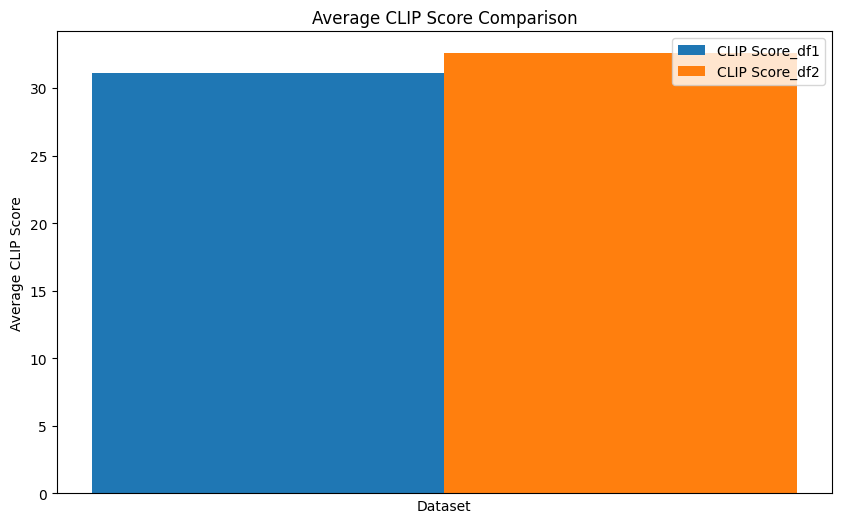

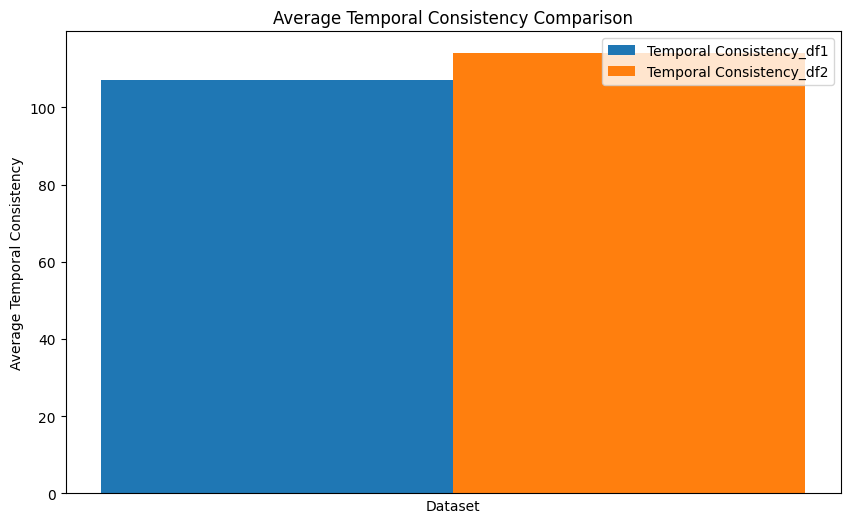

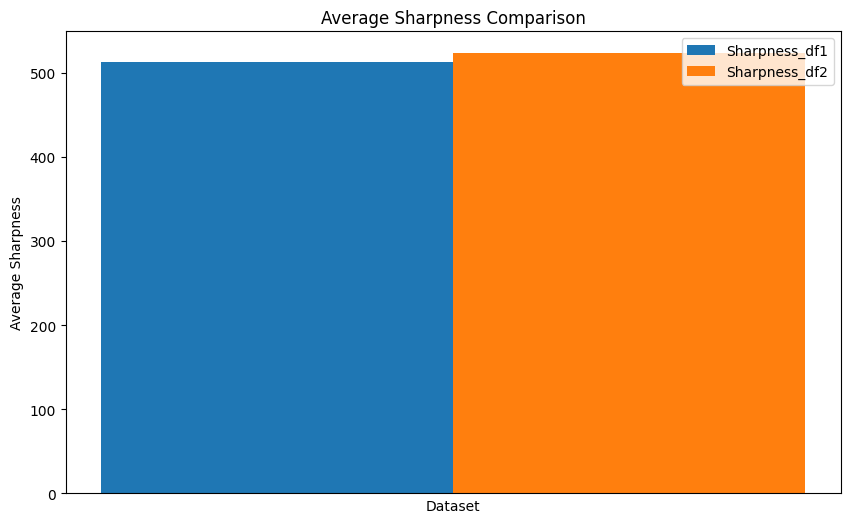

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Creating bar charts for each metric to compare averages
for i, metric in enumerate(metrics):
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(1)

    # Bar plot
    plt.bar(index, df1_means[i], bar_width, label=f"{metric}_df1")
    plt.bar(index + bar_width, df2_means[i], bar_width, label=f"{metric}_df2")

    # Adding title and labels
    plt.title(f"Average {metric} Comparison")
    plt.xlabel("Dataset")
    plt.ylabel(f"Average {metric}")
    plt.xticks([])
    plt.legend()
    plt.show()


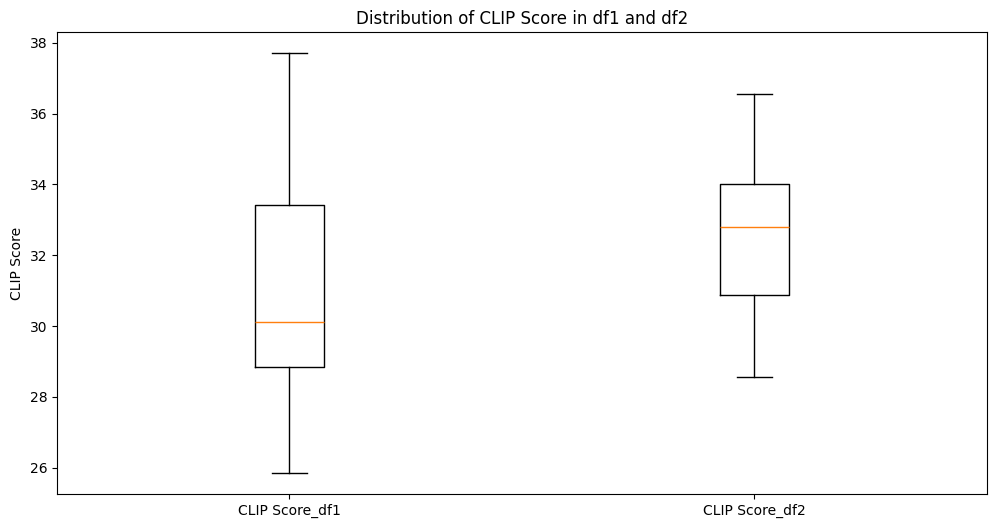

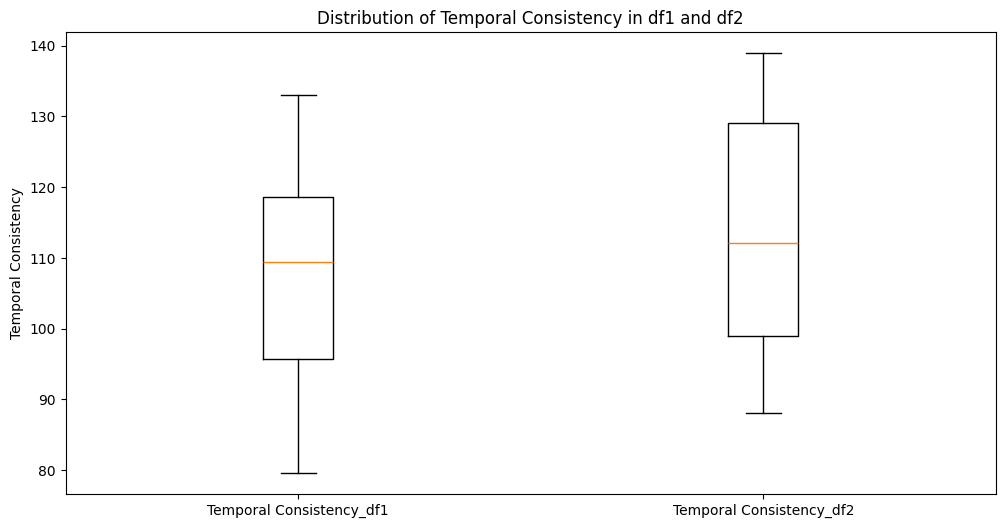

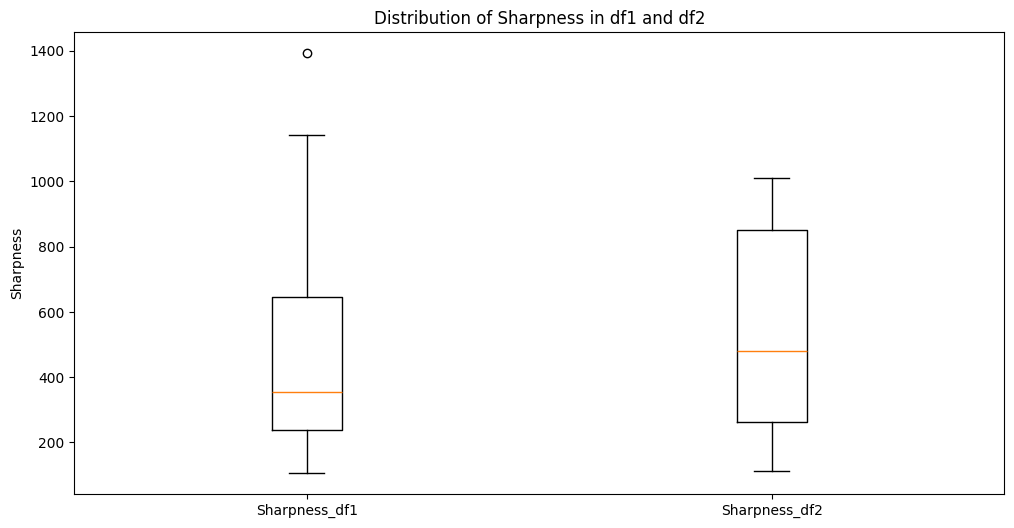

In [ ]:
# Creating box plots for a visual comparison of distributions in df1 and df2 for each metric
for metric in metrics:
    plt.figure(figsize=(12, 6))
    plt.boxplot(
        [common_files_df[f"{metric}_df1"], common_files_df[f"{metric}_df2"]],
        labels=[f"{metric}_df1", f"{metric}_df2"]
    )
    plt.title(f"Distribution of {metric} in df1 and df2")
    plt.ylabel(metric)
    plt.show()


In [ ]:
# Markdown for conclusions
markdown = """
# Comparative Study Between df1 and df2

## 1. CLIP Score Analysis
- **df1 Average CLIP Score**: {:.2f}
- **df2 Average CLIP Score**: {:.2f}
- **Conclusion**: `df2` shows a marginally higher average CLIP Score, suggesting slightly better alignment with textual prompts.

## 2. Temporal Consistency Analysis
- **df1 Average Temporal Consistency**: {:.2f}
- **df2 Average Temporal Consistency**: {:.2f}
- **Conclusion**: `df2` has a higher average Temporal Consistency, indicating potentially smoother transitions and coherence.

## 3. Sharpness Analysis
- **df1 Average Sharpness**: {:.2f}
- **df2 Average Sharpness**: {:.2f}
- **Conclusion**: Sharpness scores are similar, with `df2` having a minor edge, hinting at slightly clearer visuals.

Overall, **df2** exhibits slight improvements across metrics, particularly in **CLIP Score** and **Temporal Consistency**.
""".format(df1_means[0], df2_means[0], df1_means[1], df2_means[1], df1_means[2], df2_means[2])

print(markdown)



# Comparative Study Between df1 and df2

## 1. CLIP Score Analysis
- **df1 Average CLIP Score**: 31.10
- **df2 Average CLIP Score**: 32.56
- **Conclusion**: `df2` shows a marginally higher average CLIP Score, suggesting slightly better alignment with textual prompts.

## 2. Temporal Consistency Analysis
- **df1 Average Temporal Consistency**: 107.20
- **df2 Average Temporal Consistency**: 113.97
- **Conclusion**: `df2` has a higher average Temporal Consistency, indicating potentially smoother transitions and coherence.

## 3. Sharpness Analysis
- **df1 Average Sharpness**: 512.69
- **df2 Average Sharpness**: 522.80
- **Conclusion**: Sharpness scores are similar, with `df2` having a minor edge, hinting at slightly clearer visuals.

Overall, **df2** exhibits slight improvements across metrics, particularly in **CLIP Score** and **Temporal Consistency**.



## Percentage Difference in Metrics

In this section, we calculate the percentage difference for each metric between `df1` and `df2`. This helps quantify the relative improvement (or decline) in each metric, providing a clear picture of how `df2` compares to `df1` in terms of performance.

For example, a positive percentage indicates that `df2` has improved over `df1`, while a negative percentage indicates a decline. This analysis offers insight into which metrics saw the most significant changes.


In [ ]:
# Calculating percentage difference for each metric
percentage_differences = {
    metric: ((df2_means[i] - df1_means[i]) / df1_means[i]) * 100 for i, metric in enumerate(metrics)
}

# Displaying percentage differences
for metric, diff in percentage_differences.items():
    print(f"Percentage difference in {metric} between df1 and df2: {diff:.2f}%")


Percentage difference in CLIP Score between df1 and df2: 4.68%
Percentage difference in Temporal Consistency between df1 and df2: 6.32%
Percentage difference in Sharpness between df1 and df2: 1.97%


## Correlation Analysis Between Metrics

Here, we perform a correlation analysis to explore relationships between the metrics within each dataset (`df1` and `df2`). Understanding these correlations can help reveal how metrics interact with each other. For instance, a high correlation between CLIP Score and Temporal Consistency might suggest that improvements in one metric often correspond to improvements in the other.

This analysis uses correlation matrices for `df1` and `df2` to show these relationships and whether they remain consistent across datasets.


In [ ]:
# Correlation analysis for df1 and df2 metrics
correlation_df1 = common_files_df[["CLIP Score_df1", "Temporal Consistency_df1", "Sharpness_df1"]].corr()
correlation_df2 = common_files_df[["CLIP Score_df2", "Temporal Consistency_df2", "Sharpness_df2"]].corr()

print("Correlation matrix for df1 metrics:")
print(correlation_df1)
print("\nCorrelation matrix for df2 metrics:")
print(correlation_df2)


Correlation matrix for df1 metrics:
                          CLIP Score_df1  Temporal Consistency_df1  \
CLIP Score_df1                  1.000000                 -0.342221   
Temporal Consistency_df1       -0.342221                  1.000000   
Sharpness_df1                  -0.462290                  0.158053   

                          Sharpness_df1  
CLIP Score_df1                -0.462290  
Temporal Consistency_df1       0.158053  
Sharpness_df1                  1.000000  

Correlation matrix for df2 metrics:
                          CLIP Score_df2  Temporal Consistency_df2  \
CLIP Score_df2                  1.000000                 -0.409143   
Temporal Consistency_df2       -0.409143                  1.000000   
Sharpness_df2                  -0.567670                  0.291854   

                          Sharpness_df2  
CLIP Score_df2                -0.567670  
Temporal Consistency_df2       0.291854  
Sharpness_df2                  1.000000  


## Standard Deviation Analysis

We calculate the standard deviation for each metric in `df1` and `df2` to assess variability within each dataset. A lower standard deviation indicates that values are closer to the mean, suggesting more consistent performance. This analysis helps us understand which dataset is more stable across metrics.

By comparing the standard deviation for each metric, we can determine if one dataset is more reliable in maintaining consistent metric values.


In [ ]:
# Calculating standard deviation for each metric in df1 and df2
df1_stds = [
    common_files_df["CLIP Score_df1"].std(),
    common_files_df["Temporal Consistency_df1"].std(),
    common_files_df["Sharpness_df1"].std()
]
df2_stds = [
    common_files_df["CLIP Score_df2"].std(),
    common_files_df["Temporal Consistency_df2"].std(),
    common_files_df["Sharpness_df2"].std()
]

# Displaying standard deviations
for i, metric in enumerate(metrics):
    print(f"{metric} Standard Deviation in df1: {df1_stds[i]:.2f}")
    print(f"{metric} Standard Deviation in df2: {df2_stds[i]:.2f}")


CLIP Score Standard Deviation in df1: 3.38
CLIP Score Standard Deviation in df2: 2.54
Temporal Consistency Standard Deviation in df1: 16.28
Temporal Consistency Standard Deviation in df2: 16.95
Sharpness Standard Deviation in df1: 403.19
Sharpness Standard Deviation in df2: 321.73


## Median Comparison

To further understand the central tendency of each metric, we compare the median values between `df1` and `df2`. The median can be especially insightful when there are outliers in the data, as it provides a more robust measure of the "typical" value than the mean.

This section shows if one dataset tends to have consistently higher or lower typical values across metrics compared to the other, offering an additional perspective on the data distribution.


In [ ]:
# Calculating medians for each metric in df1 and df2
df1_medians = [
    common_files_df["CLIP Score_df1"].median(),
    common_files_df["Temporal Consistency_df1"].median(),
    common_files_df["Sharpness_df1"].median()
]
df2_medians = [
    common_files_df["CLIP Score_df2"].median(),
    common_files_df["Temporal Consistency_df2"].median(),
    common_files_df["Sharpness_df2"].median()
]

# Displaying median values
for i, metric in enumerate(metrics):
    print(f"{metric} Median in df1: {df1_medians[i]:.2f}")
    print(f"{metric} Median in df2: {df2_medians[i]:.2f}")


CLIP Score Median in df1: 30.11
CLIP Score Median in df2: 32.79
Temporal Consistency Median in df1: 109.37
Temporal Consistency Median in df2: 112.07
Sharpness Median in df1: 354.31
Sharpness Median in df2: 481.48


## Visualization of Percentage Differences

This section presents a bar chart of the percentage differences in each metric between `df1` and `df2`. This visualization helps quickly identify which metrics saw the most improvement or decline in `df2` relative to `df1`.

A positive bar indicates a percentage increase, showing an improvement in `df2` over `df1`, while a negative bar suggests a decline. This chart provides a clear, visual summary of relative changes across metrics.


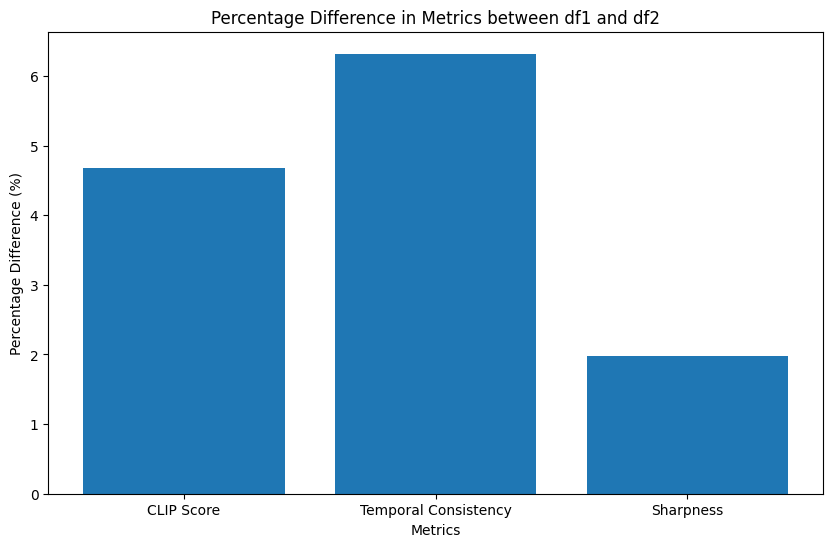

In [ ]:
# Bar chart for percentage differences
plt.figure(figsize=(10, 6))
plt.bar(percentage_differences.keys(), percentage_differences.values())
plt.title("Percentage Difference in Metrics between df1 and df2")
plt.ylabel("Percentage Difference (%)")
plt.xlabel("Metrics")
plt.show()


In [ ]:
!pip install opencv-python torch transformers lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.3 MB/s eta 0:00:00


In [ ]:
import os
import torch
import cv2
import lpips
import csv
from transformers import CLIPProcessor, CLIPModel

# Initialize LPIPS model
lpips_model = lpips.LPIPS(net='alex')

# Load CLIP model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to calculate CLIP score for each frame of the video based on text prompt
def calculate_clip_score(video_path, text_prompt):
    video = cv2.VideoCapture(video_path)
    scores = []
    while True:
        ret, frame = video.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        inputs = clip_processor(text=[text_prompt], images=frame_rgb, return_tensors="pt", padding=True)
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        scores.append(logits_per_image.item())
    video.release()
    return sum(scores) / len(scores) if scores else 0

# Function to calculate temporal consistency using optical flow
def calculate_temporal_consistency(video_path):
    video = cv2.VideoCapture(video_path)
    prev_frame = None
    consistency_scores = []
    while True:
        ret, frame = video.read()
        if not ret:
            break
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if prev_frame is not None:
            flow = cv2.calcOpticalFlowFarneback(prev_frame, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            consistency_scores.append(mag.mean())
        prev_frame = frame_gray
    video.release()
    return sum(consistency_scores) / len(consistency_scores) if consistency_scores else 0

# Function to calculate LPIPS quality score across frames
def calculate_lpips_quality(video_path):
    video = cv2.VideoCapture(video_path)
    prev_frame = None
    quality_scores = []
    while True:
        ret, frame = video.read()
        if not ret:
            break
        frame_tensor = torch.tensor(frame).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        if prev_frame is not None:
            lpips_score = lpips_model(prev_frame, frame_tensor)
            quality_scores.append(lpips_score.item())
        prev_frame = frame_tensor
    video.release()
    return sum(quality_scores) / len(quality_scores) if quality_scores else 0

# Function to calculate frame rate consistency
def calculate_frame_rate_consistency(video_path):
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    durations = []
    while True:
        ret, _ = video.read()
        if not ret:
            break
        durations.append(1 / fps)
    video.release()
    average_duration = sum(durations) / len(durations)
    consistency_score = 1 / (sum((d - average_duration)**2 for d in durations) / len(durations)) if durations else 0
    return consistency_score

# Main function to calculate all metrics for each video in a folder and save to CSV
def evaluate_videos_in_folder(folder_path, output_csv="video_metrics.csv"):
    video_metrics = {}

    # Iterate over all files in the folder
    for video_filename in os.listdir(folder_path):
        video_path = os.path.join(folder_path, video_filename)
        if video_filename.endswith(".mp4"):
            # Use filename as the text prompt (remove .mp4 extension)
            text_prompt = os.path.splitext(video_filename)[0]

            # Calculate metrics
            clip_score = calculate_clip_score(video_path, text_prompt)
            temporal_consistency = calculate_temporal_consistency(video_path)
            lpips_quality_score = calculate_lpips_quality(video_path)
            frame_rate_consistency = calculate_frame_rate_consistency(video_path)

            # Store metrics in dictionary
            video_metrics[video_filename] = [clip_score, temporal_consistency, lpips_quality_score, frame_rate_consistency]

    # Write all metrics to a CSV file
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Video", "CLIP Score", "Temporal Consistency", "LPIPS Quality", "Frame Rate Consistency"])
        for video, metrics in video_metrics.items():
            writer.writerow([video] + metrics)

# Example usage
folder_path = "/content/tuneavideo"  # Replace with your folder path
evaluate_videos_in_folder(folder_path, output_csv="video_metrics.csv")
print("Metrics evaluation completed and saved to video_metrics.csv")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

ZeroDivisionError: float division by zero